In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import matplotlib.pyplot as plt
import sys
import os
import fit_library
sys.path.append("../PETALO_DAQ_infinity/SimLib")
import config_sim as CFG
import HF_files as HF
import csv
import DAQ_infinity as DAQ

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [42]:
def CRT(path,jsonfilename,file_number,subT=False):
    # Read configuration
    SIM_CONT = CFG.SIM_DATA(filename=path+jsonfilename+".json",read=True)
    file_name = SIM_CONT.data['ENVIRONMENT']['MC_out_file_name']+"."+str(file_number)+".h5"
    # Read data file
    A = HF.hdf_access(path,file_name)
    data = A.read_DAQ_fast()
    # Generate Data Vectors
    QDC = np.array(data['/MC'])
    TDC = np.array(data['/MC_tof'])
    subth_QDC = np.array(data['/subth_QDC_L1'])
    subth_TDC = np.array(data['/subth_TDC_L1'])
    sipm2L1 = np.array(data['/sipm2L1'])
    L1_Slice, SiPM_Matrix_I, SiPM_Matrix_O, topology = DAQ.SiPM_Mapping(SIM_CONT.data,
                                                                        SIM_CONT.data['L1']['map_style'])
    SiPM_Matrix_O = SiPM_Matrix_O+1000
    SiPM_Matrix_I = SiPM_Matrix_I+1000
    ring_int_size = SIM_CONT.data['TOPOLOGY']['sipm_int_row']
    ring_ext_size = SIM_CONT.data['TOPOLOGY']['sipm_ext_row']
    
    # LOBES
    right_LOBE_I = SiPM_Matrix_I[:,0:ring_int_size//2]
    right_LOBE_O = SiPM_Matrix_O[:,0:ring_ext_size//2]
    right_LOBE = np.concatenate((right_LOBE_I,right_LOBE_O),axis=1)
    
    out = np.array([]).reshape(0,5)
    
        
    for i in range(QDC.shape[0]):
        TDC_e = TDC[i,:]
        QDC_e = QDC[i,:]
        subth_TDCe = subth_TDC[i,:]
        # Minimum TDC
        
        if np.any(TDC_e>0):

            TDC_min1 = np.min(TDC_e[TDC_e>0])      
            if np.any(subth_TDCe>0):
                TDC_min1_subth = np.min(subth_TDCe[subth_TDCe>0])
            else:
                TDC_min1_subth = 10E10
                
            # Find SiPM that generated the minimum TDC
            if TDC_min1 <= TDC_min1_subth :
                SiPM_1 = np.argwhere(TDC_e==TDC_min1)[0][0]+1000
            else:
                L1 = np.argwhere(subth_TDCe==TDC_min1_subth)
                SiPM_1 = L1_Slice[L1[0][0]][4][32]+1000
                #Select a SiPM1 inside subthr L1
                                
            if np.any(right_LOBE==SiPM_1):
                sign = -1
            else:
                sign = 1
            
            # SiPM_1 belongs to internal face
            if SiPM_1 <= SiPM_Matrix_I[-1,-1]:
                # X coordinate of SiPM_1
                SiPM_xi1 = np.argwhere(SiPM_Matrix_I==SiPM_1)[0][1]
                SiPM_xe1 = int((float(SiPM_xi1)/float(ring_int_size))*ring_ext_size)
            else:
                # SiPM_1 belongs to external face
                SiPM_xe1 = np.argwhere(SiPM_Matrix_O==SiPM_1)[0][1]
                SiPM_xi1 = int((float(SiPM_xe1)/float(ring_ext_size))*ring_int_size)


            # Roll SiPM Matrixes to find opposite side of detector
            Xi=np.roll(SiPM_Matrix_I,-SiPM_xi1+ring_int_size//4)
            Xe=np.roll(SiPM_Matrix_O,-SiPM_xe1+ring_ext_size//4)
                       
            # Select opposite side of detector
            Xi_sel = Xi[:,ring_int_size//2:]-1000
            Xe_sel = Xe[:,ring_ext_size//2:]-1000                
            Xi_sel_1D = Xi_sel.reshape(-1)
            Xe_sel_1D = Xe_sel.reshape(-1)

            TDC_min2 = 1E10
            
            
            for i in Xi_sel_1D:
                if ((TDC_min2 > TDC_e[i]) and (TDC_e[i]>0)):
                    TDC_min2 = TDC_e[i]
                    SiPM_2 = i+1000
                if (subth_TDCe[int(sipm2L1[i])]<TDC_min2 and subth_TDCe[int(sipm2L1[i])]>0):
                    TDC_min2 = subth_TDCe[int(sipm2L1[i])]
                    SiPM_2 = L1_Slice[int(sipm2L1[i])][4][32]+1000
                    print "BINGO"
                # Find L1!!!!
            
            for i in Xe_sel_1D:
                if ((TDC_min2 > TDC_e[i]) and (TDC_e[i]>0)):
                    TDC_min2 = TDC_e[i]
                    SiPM_2 = i+1000
                if (subth_TDCe[int(sipm2L1[i])]<TDC_min2 and subth_TDCe[int(sipm2L1[i])]>0):
                    TDC_min2 = subth_TDCe[int(sipm2L1[i])]
                    SiPM_2 = L1_Slice[int(sipm2L1[i])][4][32]+1000
                    print "BINGO"
                       # Find L1!!!!
            
                
                
            if TDC_min2 == 1E10:
                SiPM_2   = 0
                TDC_min2 = 0

            SiPM_1_aux = SiPM_1
        
        else:
            TDC_min1 = 0
            TDC_min2 = 0 
            SiPM_1_aux = 0
            SiPM_2 = 0
        
        
        out = np.vstack([out,[TDC_min1,TDC_min2,SiPM_1_aux,SiPM_2,sign]])
       
    return out,subth_TDC
    

In [43]:
path = "/home/viherbos/DAQ_DATA/NEUTRINOS/LESS_4mm/"
jsonfilename = "infinity_striped_2"
file_number = 0

out,subth_TDC = CRT(path,jsonfilename,file_number)

{u'ENVIRONMENT': {u'path_to_files': u'/home/viherbos/DAQ_DATA/NEUTRINOS/LESS_4mm/', u'n_files': 5, u'file_name': u'p_FR_infinity_4mm_', u'time_bin': 5, u'MC_file_name': u'full_ring_depth3cm_pitch4mm', u'out_file_name': u'daq_output', u'temperature': 300, u'n_events': 30000, u'MC_out_file_name': u'daq_output_IDEAL', u'ch_rate': 10000000.0}, u'SIPM': {u'size': [1, 3, 3]}, u'TOPOLOGY': {u'radius_ext': 1294, u'n_rows': 16, u'sipm_ext_row': 204, u'radius_int': 994, u'sipm_int_row': 157}, u'TOFPET': {u'TGAIN': 1, u'TE': 3, u'outlink_rate': 32500000.0, u'OUT_FIFO_depth': 256, u'n_channels': 64, u'IN_FIFO_depth': 4, u'MAX_WILKINSON_LATENCY': 5120}, u'L1': {u'L1_mapping_O': [7, 7, 8, 7, 7, 7, 8], u'frame_process': 3000000.0, u'L1_mapping_I': [8, 8, 8, 8, 8], u'L1_outrate': 550000000.0, u'n_asics': 16, u'map_style': u'striped_2', u'FIFO_L1b_depth': 128, u'FIFO_L1a_depth': 4096, u'buffer_size': 512, u'TE': 9}}
Number of SiPM : 5776 
Number of ASICS : 91 
Minimum Number of L1 : 6 
Available ASICS 

BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BINGO
BING

In [44]:
cond1 = out[:,0]>0 
cond2 = out[:,1]>0

cond = cond1*cond2
CRT = out[cond,:]
sel_CRT = (CRT[:,1]-CRT[:,0])*CRT[:,4]
sel_CRT = sel_CRT[np.abs(sel_CRT)<1000]

<IPython.core.display.Javascript object>


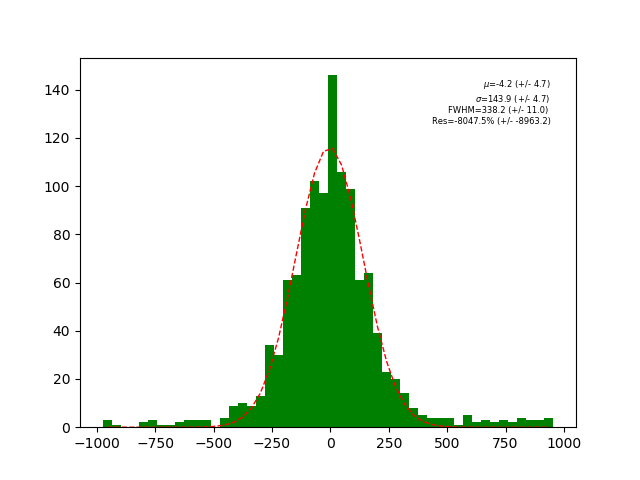

In [45]:
fit = fit_library.gauss_fit()
fig = plt.figure()
fit(sel_CRT,50)
fit.plot(fig.add_subplot(111),'','','',res=True,fit=True)

In [41]:
# Subthreshold analysis
subth_TDC_aux = np.zeros(subth_TDC.shape[0])
for i in range(subth_TDC.shape[0]):
    aux = subth_TDC[i,:]
    if np.all(aux==0):
        subth_TDC_aux[i] = 0
    else:
        subth_TDC_aux[i] = np.min(aux[np.nonzero(aux)])

cond1a = out[:,0]>0 
cond2a = subth_TDC_aux>0

print("Number of Subthreshold TDC lower than TDC1 = %d in %d total events" 
          % (np.sum(subth_TDC_aux[cond1a*cond2a]<out[cond1a*cond2a,0]),subth_TDC.shape[0]))

Number of Subthreshold TDC lower than TDC1 = 756 in 6607 total events
